In [1]:
import os
os.chdir("/Users/ainsleylewis/Documents/Astronomy/IllustrisTNG Lens Modelling")
import re

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
from error_propagation import Complex
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry, IterativePSFPhotometry
from photutils.psf import make_psf_model_image, CircularGaussianPSF, GaussianPSF, MoffatPSF
from tqdm import tqdm
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import emcee
norm = ImageNormalize(stretch=SqrtStretch())

# Galfic Plotting Code
from astropy.io import fits
import warnings
warnings.filterwarnings('ignore')

# Glafic Tabular 

# Read_script.py
# Open the Python file as a text file
def glafic_tabular(filename_0, filename_6, save_table_flag = False, shear = False, show_shear = False, show_params = False):
    with open(filename_0, 'r') as file:
        content = file.read()
        file.close()
    
    with open(filename_6, 'r') as file:
        content_opt = file.read()
        file.close()

    def find_line(word, content):
        content = content.split('\n')
        line_number = 0
        for line in content:
            line_number += 1
            if word in line:
                return line_number
        return "Line Not Found"
    
    def find_last_line(word, content):
        content = content.split('\n')
        line_number = 0
        last_occurrence = -1
        for line in content:
            line_number += 1
            if word in line:
                last_occurrence = line_number
        return last_occurrence

    content_list = content.split('\n')

    if shear == True:
        # --- FIX STARTS HERE ---
        # Instead of hardcoding '2', we will find the 'pert' lens dynamically.
        pert_lens_number = None
        set_lens_pert_line_content = None

        for line in content_list:
            # Find the line that defines the 'pert' lens model
            if 'glafic.set_lens(' in line and "'pert'" in line:
                set_lens_pert_line_content = line
                # Extract the lens number from the line "glafic.set_lens(N, 'pert', ...)"
                try:
                    # Split by '(' and then by ',' to isolate the number
                    pert_lens_number = int(line.split('(')[1].split(',')[0].strip())
                except (ValueError, IndexError):
                    raise ValueError(f"Could not parse lens number from 'pert' line: {line}")
                break # Stop after finding the first one

        # If no 'pert' lens was found in the entire file
        if pert_lens_number is None:
            raise ValueError("Shear mode is on, but no lens with model 'pert' was found in the file.")

        # Now, dynamically find the corresponding setopt_lens line using the number we found
        setopt_search_string = f'glafic.setopt_lens({pert_lens_number},'
        line_opt_pert_num = find_line(setopt_search_string, content)

        if line_opt_pert_num == "Line Not Found":
            raise ValueError(f"Found 'pert' lens {pert_lens_number}, but could not find its corresponding 'setopt_lens' line.")
        
        # Get the content of the setopt line
        setopt_lens_pert_line_content = content_list[line_opt_pert_num - 1]
        
        # The rest of the logic is the same, just using our dynamically found lines
        parts_set_lens_2 = set_lens_pert_line_content.split(',')
        parts_set_lens_2 = [part.strip().strip("'") for part in parts_set_lens_2]

        parts_setopt_lens_2 = setopt_lens_pert_line_content.split(',')
        parts_setopt_lens_2 = [part.strip().strip("'") for part in parts_setopt_lens_2]

        name = 'Shear'
        z_s = parts_set_lens_2[3]
        x = parts_set_lens_2[4]
        y = parts_set_lens_2[5]
        gamma = parts_set_lens_2[6]
        pa = parts_set_lens_2[7]
        NaN = parts_set_lens_2[8]
        pwi = parts_set_lens_2[9].replace(')', '') 

        z_s_flag = parts_setopt_lens_2[2]
        x_flag = parts_setopt_lens_2[3]
        y_flag = parts_setopt_lens_2[4]
        gamma_flag = parts_setopt_lens_2[5]
        pa_flag = parts_setopt_lens_2[6]
        NaN_flag = parts_setopt_lens_2[7]
        pwi_flag = parts_setopt_lens_2[8].replace(')', '') 

        line = find_last_line('lens   pert', content_opt)
        line_content = content_opt.split('\n')[line - 1]
        line_list = line_content.split()

        row_0 = [name, '$z_{s,fid}$', 'x', 'y', 'γ', '$θ_{γ}$', 'NaN', 'κ']
        row_1 = ['Input Value', z_s, x, y, gamma, pa, NaN, pwi]
        row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
        row_3 = ['Fixed', z_s_flag, x_flag, y_flag, gamma_flag, pa_flag, NaN_flag, pwi_flag]

        table_shear = pd.DataFrame([row_1, row_2, row_3], columns = row_0)
        if show_shear:
            print(table_shear)

        if save_table_flag:
            table_shear.to_csv('shear_table.csv')
            
        return table_shear
        # --- FIX ENDS HERE ---

    # --- This is the non-shear part of the function, it remains unchanged ---
    line_set_1 = find_line('glafic.set_lens(1,', content)
    line_opt_1 = find_line('glafic.setopt_lens(1,', content)

    if line_set_1 == "Line Not Found" or line_opt_1 == "Line Not Found":
        raise ValueError("Failed to find lens or setopt lens lines in the glafic file.")
    
    set_lens_1 = content_list[line_set_1-1]
    setopt_lens_1 = content_list[line_opt_1-1]
    
    models = ['SIE', 'POW', 'NFW', 'EIN']

    parts_set_lens = set_lens_1.split(',')
    parts_set_lens = [part.strip().strip("'") for part in parts_set_lens]

    parts_setopt_lens = setopt_lens_1.split(',')
    parts_setopt_lens = [part.strip().strip("'") for part in parts_setopt_lens]
    
    for i in models:
        i = i.lower()
        if i in set_lens_1:
            if i == models[1].lower(): # POW model
                name = models[1]
                z_s = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                r_ein = parts_set_lens[8]
                pwi = parts_set_lens[9].replace(')', '') 

                z_s_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                r_ein_flag = parts_setopt_lens[7]
                pwi_flag = parts_setopt_lens[8].replace(')', '') 

                line = find_last_line('lens   pow', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, '$z_{s,fid}$', 'x', 'y', 'e', '$θ_{e}$', '$r_{Ein}$', 'γ (PWI)']
                row_1 = ['Input Value', z_s, x, y, e, pa, r_ein, pwi]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', z_s_flag, x_flag, y_flag, e_flag, pa_flag, r_ein_flag, pwi_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)

            elif i == models[0].lower(): # SIE model
                name = models[0]
                sigma = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                r_core = parts_set_lens[8]
                pwi = parts_set_lens[9].replace(')', '') 

                sigma_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                r_core_flag = parts_setopt_lens[7]
                pwi_flag = parts_setopt_lens[8].replace(')', '') 

                line = find_last_line('lens   sie', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, 'σ', 'x', 'y', 'e', '$θ_{e}$', '$r_{core}$', 'NaN']
                row_1 = ['Input Value', sigma, x, y, e, pa, r_core, pwi]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', sigma_flag, x_flag, y_flag, e_flag, pa_flag, r_core_flag, pwi_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)

            elif i == models[2].lower(): # NFW model    
                name = models[2]
                m = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                c = parts_set_lens[8]
                Nan = parts_set_lens[9].replace(')', '') 

                m_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                c_flag = parts_setopt_lens[7]
                Nan_flag = parts_setopt_lens[8].replace(')', '')

                line = find_last_line('lens   anfw', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, 'M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', 'NaN']
                row_1 = ['Input Value', m, x, y, e, pa, c, Nan]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', m_flag, x_flag, y_flag, e_flag, pa_flag, c_flag, Nan_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)
            
            elif i == models[3].lower(): # EIN model
                name = models[3]
                m = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                ce_rs = parts_set_lens[8]
                alpha_e = parts_set_lens[9].replace(')', '')

                m_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                ce_rs_flag = parts_setopt_lens[7]
                alpha_e_flag = parts_setopt_lens[8].replace(')', '')

                line = find_last_line('lens   ein', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, 'M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', '$α_{e}$']
                row_1 = ['Input Value', m, x, y, e, pa, ce_rs, alpha_e]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', m_flag, x_flag, y_flag, e_flag, pa_flag, ce_rs_flag, alpha_e_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)
            
            if show_params:
                print(table)

            if save_table_flag:
                table.to_csv('table.csv')
            
            return table, chi_list

    print("Model not found")
    return None, None



# Position and Magnification Plots

def error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, title, 
               table_flag = False, glafic_file_1=None, glafic_file_2=None, shear = False, show_shear = False, show_params = False):
    
    if table_flag:
        if glafic_file_1 is None:
            print("Please provide the filename for the glafic script")
            raise ValueError("Glafic File not provided")
        elif glafic_file_2 is None:
            print("Please provide the Opt Result filename for the glafic script")
            raise ValueError("Glafic File not provided")

    if table_flag:    
        table, chi2 = glafic_tabular(glafic_file_1, glafic_file_2, show_params=show_params)
        if table is None:
            raise ValueError("Failed to create the table from the glafic file.")

    if shear:
        table_shear = glafic_tabular(glafic_file_1, glafic_file_2, shear = True, show_shear = show_shear, show_params=show_params)
        if table_shear is None:
            raise ValueError("Failed to create the table from the glafic file.")
        
    # Storage for parsed data
    data = []
    
    # val = pd.read_csv(filename_4)
    # val.__dataframe__
    # val_column = val.columns[0]

    # # Split the values in the data_column and expand into separate columns
    # val = val[val_column].str.split(expand=True)

    # # Convert the DataFrame to numeric type
    # val = val.apply(pd.to_numeric)

    # print(val)

    with open(filename_2, 'r') as file:
        for line in file:
            # Skip lines starting with "#"
            if line.startswith("#"):
                continue
            
            # Split the line by whitespace
            line_data = line.split()
            
            # Remove # 
            line_data = [float(val) for val in line_data if val != '#']  
            
            data.append(line_data)
    
    val = pd.DataFrame(data)
    val = val.iloc[1:]
    brightest_flux = max(val[2])
    brightest_index = val[2].idxmax()

    # Add a column called 'colour' to val
    val['colour'] = ''

    # Assign 'red' to the brightest image
    val.at[brightest_index, 'colour'] = 'red'

    # Get the coordinates of the brightest image
    brightest_x = val.at[brightest_index, 0]
    brightest_y = val.at[brightest_index, 1]

    # Calculate the angles of the other images relative to the brightest image
    angles = np.arctan2(val[1] - brightest_y, val[0] - brightest_x)

    # Sort the indices of the images by angle in clockwise order
    sorted_indices = angles.sort_values(ascending=False).index

    # Assign colours to the remaining images
    colours = ['green', 'yellow', 'blue']
    colour_index = 0
    for idx in sorted_indices:
        if val.at[idx, 'colour'] == '':
            val.at[idx, 'colour'] = colours[colour_index]
            colour_index += 1
    
    val['flux_ratio'] = abs(val[2] / brightest_flux)

    err_1 = Complex(val[2][1], val[4][1])
    err_2 = Complex(val[2][2], val[4][2])
    err_3 = Complex(val[2][3], val[4][3])
    err_4 = Complex(val[2][4], val[4][4])

    ratio_1 = str(Complex.truediv(err_1, err_2))
    ratio_2 = str(Complex.truediv(err_2, err_2))
    ratio_3 = str(Complex.truediv(err_3, err_2))
    ratio_4 = str(Complex.truediv(err_4, err_2))

    ratio_1_error = float(ratio_1.split(' ± ')[1])
    ratio_2_error = float(ratio_2.split(' ± ')[1])
    ratio_3_error = float(ratio_3.split(' ± ')[1])
    ratio_4_error = float(ratio_4.split(' ± ')[1])

    val['flux_ratio_error'] = [ratio_1_error, ratio_2_error, ratio_3_error, ratio_4_error]

    data = []

    # Line by line read (Remove # from obs file)
    with open(filename_1, 'r') as file:
        for line in file:
            # Skip lines starting with "#"
            if line.startswith("#"):
                continue
            
            # Split the line by whitespace
            line_data = line.split()
            
            # Remove # 
            line_data = [float(val) for val in line_data if val != '#']  
            
            data.append(line_data)
    
    # Convert to DataFrame
    data_df = pd.DataFrame(data)

    # Exclude the first row
    data_df = data_df.iloc[1:]
    
    data_df.insert(8, "Label", val['colour'].map({'red': 'Red Image', 'green': 'Green Image', 'yellow': 'Yellow Image', 'blue': 'Blue Image'}), True)

    # Reorder the images according to the order red, green, yellow, blue
    order = ['Red Image', 'Green Image', 'Yellow Image', 'Blue Image']
    data_df['Label'] = pd.Categorical(data_df['Label'], categories=order, ordered=True)
    data_df = data_df.sort_values('Label').reset_index(drop=True)

    data_df = data_df.drop(columns =[3, 5, 6, 7])

    # Read and process the predicted data
    data_pred = pd.read_csv(filename_4, header=None, delim_whitespace=True, comment='#')
    df_pred = data_pred.iloc[1:]

    obs_point = data_df[[0, 1]].reset_index(drop=True)
    pred_point = df_pred[[0, 1]].reset_index(drop=True)

    # Row Switching
    dist_matrix = cdist(obs_point.to_numpy(), pred_point.to_numpy(), 'euclidean')

    obs_indices, pred_indices_optimal = linear_sum_assignment(dist_matrix)

    pred_point_sorted = pred_point.iloc[pred_indices_optimal].reset_index(drop=True)

    df_pred_sorted_full = df_pred.iloc[pred_indices_optimal].reset_index(drop=True)

    df_pred = df_pred_sorted_full
    df_pred = df_pred.drop(columns =[3])


    # Eliminating the 5th image
    if len(df_pred[2])>num_images:
        i = len(df_pred[2]) - num_images
        for j in range(i):
            min_vales = np.min(abs(df_pred[2]))
            df_2 = abs(df_pred)
            b = df_2.index.get_loc(df_2[df_2[2] == min_vales].index[0])
            df_3 = df_pred.drop((b+1), axis='index')
            df_pred = df_3
            df_pred.reset_index(drop=True, inplace=True)
        df_pred.index = df_pred.index + 1

    df_pred = df_pred.reset_index(drop=True)

    # Calculations for Position Error values
    d_x = (abs(data_df[0]) - abs(df_pred[0])).abs()
    d_y = (abs(data_df[1]) - abs(df_pred[1])).abs()
    sum_sq = (d_x**2) + (d_y**2)
    sq = np.sqrt(sum_sq)
    rms = np.average(sq)
    rms_unit = rms*1000
    rms_round = round(rms_unit, 3)/1000
    rms_str = str(rms_round)

    # Plotting Position Error Graph
    # custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    # sns.set_theme(style="ticks", rc=custom_params)

    colours1 = ['lightsalmon', 'green', 'gold', 'blue']
    plt.figure(figsize=(15, 5), dpi=500)
    plt.subplot(1, 3, 1)
    plt.bar(data_df['Label'], sq, color = colours1, width=0.3)
    plt.axhline(xmin=0.045, xmax=0.13, y=1.28/1000, linestyle ='--', color ='r', linewidth = 2, label='1 σ Error')
    plt.axhline(xmin=0.32, xmax=0.40, y=0.85/1000, linestyle ='--', color ='r', linewidth = 2)
    plt.axhline(xmin=0.6, xmax=0.68, y=0.83/1000, linestyle ='--', color ='r', linewidth = 2)
    plt.axhline(xmin=0.87, xmax=0.95, y=0.39/1000, linestyle ='--', color ='r', linewidth = 2)
    plt.title('Position Diagnostic (ΔRMS = ' + rms_str + ')', fontsize=10)
    plt.legend(loc='upper right', fontsize='small')
    plt.xticks(fontsize=8)
    plt.ylim(0, max(sq)+0.005)
    plt.xlabel('Images')
    plt.ylabel('Positional offset')

    # Calculations for Magnification value
    # Previous Code: f = df_pred[2][1]
    max_flux = max(abs(df_pred[2]))
    flux_ratio = df_pred[2]/max_flux
    df_pred[3] = abs(flux_ratio)

    # Create data 
    x = np.arange(4)
    width = 0.3

    # FITS image processing for predicted flux at observed positions 
    image = fits.open(filename_5)
    values = 1/image[0].data
    image.close()
    dat = values[6]
    g = (data_df[0]/0.01).astype(int) - 2000
    h = (data_df[1]/0.01).astype(int) - 2000

    g_max = (g + 1).astype(int)
    h_max = (h + 1).astype(int)
    g_min = (g - 1).astype(int)
    h_min = (h - 1).astype(int)


    flux_pos = []
    flux_pos_max = []
    flux_pos_min = []

    for i in range(0,4):
        flux_cal = dat[h[i]][g[i]]
        flux_pos.append(abs(flux_cal))
    

    for i in range(0,4):
        flux_cal_max = dat[h_max[i]][g_max[i]]
        flux_pos_max.append(abs(flux_cal_max))

    
    for i in range(0,4):
        flux_cal_min = dat[h_min[i]][g_min[i]]
        flux_pos_min.append(abs(flux_cal_min))
    
    arrow_legnths = (np.array(flux_pos_max) - np.array(flux_pos_min))/100
    # arrow_legnths = [0,0,0,0]
    true_flux = np.array(flux_pos)

    # Switch columns of val according to the previous colour indexing
    val = val.set_index('colour').loc[['red', 'green', 'yellow', 'blue']].reset_index()

    height = max(val[2]) + 5
    # Plotting Flux Error Graph
    plt.subplot(1, 3, 2)
    plt.bar(x+0.15, val[2], width, color='red', edgecolor ='k', label = 'μ_obs/μ_ref') 
    plt.bar(x-0.15, abs(df_pred[2]), width, color='white', edgecolor='k', hatch='\\/', label='μ_pred/μ_ref') 
    plt.bar(x+0.45, true_flux, width, color='orange', edgecolor='k', label = 'µ_pred/μ_ref (obs pos)')
    # plt.errorbar(x-0.15, val[0], yerr=3*(val[1]), fmt='o', color='black', capsize=4, label='3 σ Error') (OLD ERROR BAR)
    plt.errorbar(x+0.15, val[2], yerr=val[4], fmt='.', color='black', capsize=5, label='1 σ Error')
    plt.xticks(x+0.15, data_df['Label'], fontsize=8) 
    plt.arrow(x[0]+0.45, true_flux[0], 0, arrow_legnths[0], head_width=0.1, head_length=0.4, fc='k', ec='k')
    plt.arrow(x[0]+0.45, true_flux[0], 0, -arrow_legnths[0], head_width=0.1, head_length=0.4, fc='k', ec='k')
    plt.arrow(x[1]+0.45, true_flux[1], 0, arrow_legnths[1], head_width=0.1, head_length=0.4, fc='k', ec='k')
    plt.arrow(x[1]+0.45, true_flux[1], 0, -arrow_legnths[1], head_width=0.1, head_length=0.4, fc='k', ec='k')
    plt.arrow(x[2]+0.45, true_flux[2], 0, arrow_legnths[2], head_width=0.1, head_length=0.4, fc='k', ec='k')
    plt.arrow(x[2]+0.45, true_flux[2], 0, -arrow_legnths[2], head_width=0.1, head_length=0.4, fc='k', ec='k')
    plt.arrow(x[3]+0.45, true_flux[3], 0, arrow_legnths[3], head_width=0.1, head_length=0.4, fc='k', ec='k')
    plt.arrow(x[3]+0.45, true_flux[3], 0, -arrow_legnths[3], head_width=0.1, head_length=0.4, fc='k', ec='k')
    plt.xlabel("Images") 
    plt.ylabel("Magnifications") 
    plt.ylim()
    plt.legend(loc = 'upper right', fontsize='small')
    plt.title('Magnification Diagnostic', fontsize=10)
    plt.suptitle(title)
    if table_flag:
        table_plot = plt.table(cellText=table.values, colLabels=table.columns, cellLoc = 'center', loc='bottom', bbox=[-1.0, -0.5, 3.0, 0.3])
        table_plot.auto_set_font_size(False)
        table_plot.set_fontsize(10)
        plt.suptitle('Lens ' + plot_name + ' constrained' + ' (Chi2 = ' + chi2[2] + ')')
        if shear == True:
            table_shear_plot = plt.table(cellText=table_shear.values, colLabels=table_shear.columns, cellLoc = 'center', loc='bottom', bbox=[-1.0, -0.9, 3.0, 0.3])
            table_shear_plot.auto_set_font_size(False)
            table_shear_plot.set_fontsize(10)

    return data_df, df_pred



# Critical Curves Plot

def critcurve_plot(filename_4, filename_3, pos_output, num_images):
    data_crit = pd.read_csv(filename_3, header= None, sep="\s+")
    data_crit.__dataframe__
    df = data_crit.iloc[1:]

    obs = pd.DataFrame(pos_output)

    # Initialize empty list 
    data = []

    # Read and process the predicted data
    de = pd.read_csv(filename_4, header=None, delim_whitespace=True, comment='#')
    de = de.iloc[1:]

    # Function for swapping data 
    def swap_rows(df, row1, row2):
        df.iloc[row1], df.iloc[row2] =  df.iloc[row2].copy(), df.iloc[row1].copy()
        return df
    
    # For loop to iterate over row range for row swapping
    for i in range(4):
        diff = abs(abs(obs.iloc[i,0]) - abs(de[0]))
        m = diff.idxmin()
        n = min(diff)
        if n < 0.1:
            de = swap_rows(de, i, (m-1))
        else:
            continue

        
    de = de.drop(columns =[3])

    # Eliminating the 5th image
    if len(de[2])>num_images:
        i = len(de[2]) - num_images
        for j in range(i):
            min_vales = np.min(abs(de[2]))
            df_4 = abs(de)
            b = df_4.index.get_loc(df_4[df_4[2] == min_vales].index[0])
            df_5 = de.drop((b+1), axis='index')
            de = df_5
            de.reset_index(drop=True, inplace=True)
        de.index = de.index + 1

    labels = ['A', 'B', 'C', 'D']

    # Plotting Critial Curves
    plt.subplot(1, 3, 3)
    plt.scatter(df[0]/0.04, df[1]/0.04, s=2, color = 'orange', label = 'Critical Curve')
    plt.scatter(df[2]/0.04, df[3]/0.04, s=2)
    plt.scatter(df[4]/0.04, df[5]/0.04, s=2)
    plt.scatter(df[6]/0.04, df[7]/0.04, s=2, label = 'Caustics')

    height_1 = max(df[0]/0.04)
    height_2 = max(df[1]/0.04)

    # colors = ['red',  'blue', 'green', 'gold']
    colors = obs['Label'].map({'Red Image': 'red', 'Green Image': 'green', 'Yellow Image': 'gold', 'Blue Image': 'blue'}).tolist()

    # Plotting obs image positions and labels 
    plt.scatter(de[0]/0.04, de[1]/0.04, s = 100, marker= '+', color = colors, alpha = 0.5, label = 'Predicted Position')
    plt.scatter(obs[0]/0.04, obs[1]/0.04, s=15, color = colors, marker = 'o', label = 'Observed Position')
    # for x, y, txt in zip(data_df[0]*100, data_df[1]*100, labels):
    #     plt.text(x, y-17, txt, fontsize=13, ha='center', va='bottom')

    plt.title('Critical Curves and Caustics', fontsize=10)
    plt.legend(loc='upper right', fontsize='small')
    plt.tick_params(labelsize=8)
    plt.xlabel('x [Pixel]')
    plt.ylabel('y [Pixel]', labelpad=0)
    # Calculate the natural limits of the graph
    x_min, x_max = min(df[0]/0.04), max(df[0]/0.04)
    y_min, y_max = min(df[1]/0.04), max(df[1]/0.04)

    # Define a zoom factor
    zoom_factor = 0.2

    # Calculate the limits with the zoom factor
    x_range = (x_max - x_min) * zoom_factor
    y_range = (y_max - y_min) * zoom_factor

    plt.xlim(x_min - x_range, x_max + x_range)
    plt.ylim(y_min - y_range, y_max + y_range)

    plt.show()


    
    return df

In [3]:
# Define function to make both tables
def make_tables(model_ver, model_path, constraint):
    # Load the data
    with open(model_path + '/' + model_ver + '_optresult' + '.dat', 'r') as file:
        opt_result = file.readlines()

    # Find the last line with 'optimize' in it
    last_optimize_index = None
    for idx in range(len(opt_result) - 1, -1, -1):
        if 'optimize' in opt_result[idx]:
            last_optimize_index = idx
            last_optimize_line = opt_result[idx]
            break
    if last_optimize_index is None:
        raise ValueError("No line with 'optimize' found in the file.")

    # Extract everything after the last 'optimize' line
    opt_result = opt_result[last_optimize_index + 1:]

    # Count the number of lines that start with 'lens'
    lens_count = sum(1 for line in opt_result if line.startswith('lens'))

    # Initialize a dictionary to hold the lens parameters
    lens_params_dict = {}

    # Extract the lens parameters
    lens_params = []
    for line in opt_result:
        if line.startswith('lens'):
            parts = re.split(r'\s+', line.strip())
            lens_name = parts[1]
            params = [float(x) for x in parts[2:]]

            # Store the parameters in the dictionary
            lens_params_dict[lens_name] = params
            lens_params.append((lens_name, params))

    # Remove the first lens parameter
    if lens_params:
        for i in range(len(lens_params)):
            lens_name, params = lens_params[i]
            lens_params_dict[lens_name] = params[1:]

    # Number of len profiles
    num_lens_profiles = len(lens_params_dict)

    # Use generic column names: param1, param2, ...
    df = pd.DataFrame()
    rows = []
    max_param_len = 0

    for lens_name, params in lens_params_dict.items():
        row = {'Lens Name': lens_name}
        for i, val in enumerate(params):
            row[f'param{i+1}'] = val
        rows.append(row)
        if len(params) > max_param_len:
            max_param_len = len(params)

    columns = ['Lens Name'] + [f'param{i+1}' for i in range(max_param_len)]
    df = pd.DataFrame(rows, columns=columns)
    
    # Load the input parameters from the Python file
    with open(model_path + '/' + constraint + '_point' + '.py', 'r') as file:
        py = file.readlines()

    # Extracting the input parameters from the Python file
    set_lens_lines = [line for line in py if line.startswith('glafic.set_lens(')]
    if not set_lens_lines:
        raise ValueError("No lines starting with 'glafic.set_lens(' found in the file.")

    set_lens_params = []
    for line in set_lens_lines:
        match = re.search(r'set_lens\((.*?)\)', line)
        if match:
            params_str = match.group(1)
            params = [param.strip() for param in params_str.split(',')]
            set_lens_params.append(params)
        else:
            raise ValueError(f"No valid parameters found in line: {line.strip()}")

    # Store the parameters in a dictionary
    set_lens_dict = {}
    for params in set_lens_params:
        if len(params) < 3:
            raise ValueError(f"Not enough parameters found in line: {params}")
        lens_name = params[1].strip("'\"")  # Remove quotes from lens name
        lens_params = [float(x) for x in params[2:]]  # Skip index and lens name
        set_lens_dict[lens_name] = lens_params

    # Remove the first lens parameter
    if set_lens_dict:
        for lens_name, params in set_lens_dict.items():
            set_lens_dict[lens_name] = params[1:]  # Remove the first parameter (index)

    # Use generic column names: param1, param2, ...
    df_input = pd.DataFrame()
    rows_input = []
    max_param_len_input = 0
    for lens_name, params in set_lens_dict.items():
        row = {'Lens Name': lens_name}
        for i, val in enumerate(params):
            row[f'param{i+1}'] = val
        rows_input.append(row)
        if len(params) > max_param_len_input:
            max_param_len_input = len(params)
    columns_input = ['Lens Name'] + [f'param{i+1}' for i in range(max_param_len_input)]
    df_input = pd.DataFrame(rows_input, columns=columns_input)
    
    # Extract input flags from the Python file
    set_flag_lines = [line for line in py if line.startswith('glafic.setopt_lens(')]
    if not set_flag_lines:
        raise ValueError("No lines starting with 'glafic.setopt_lens(' found in the file.")
    set_flag_params = []
    for line in set_flag_lines:
        match = re.search(r'setopt_lens\((.*?)\)', line)
        if match:
            params_str = match.group(1)
            params = [param.strip() for param in params_str.split(',')]
            set_flag_params.append(params)
        else:
            raise ValueError(f"No valid parameters found in line: {line.strip()}")
    
    # Store the parameters in a dictionary
    set_flag_dict = {}
    for params in set_flag_params:
        if len(params) < 2:
            raise ValueError(f"Not enough parameters found in line: {params}")
        # The lens name is not present in setopt_lens, so use the lens index to map to set_lens_dict
        lens_index = params[0].strip("'\"")
        # Find the lens name corresponding to this index from set_lens_params
        lens_name = None
        for lens_params in set_lens_params:
            if lens_params[0].strip("'\"") == lens_index:
                lens_name = lens_params[1].strip("'\"")
                break
        if lens_name is None:
            raise ValueError(f"Lens name for index {lens_index} not found in set_lens_params")
        flag = ','.join(params[1:])  # Join all flag values as a string
        set_flag_dict[lens_name] = flag
   
    # Remove the first flag parameter
    if set_flag_dict:
        for lens_name, flag in set_flag_dict.items():
            flag_parts = flag.split(',')
            set_flag_dict[lens_name] = ','.join(flag_parts[1:])  # Remove the first flag parameter
    
    # Dynamically create columns: 'Lens Name', 'flag1', 'flag2', ..., based on the maximum number of flags
    df_flag = pd.DataFrame()
    rows_flag = []
    max_flag_len = 0
    
    # First, determine the maximum number of flags
    for flag in set_flag_dict.values():
        flag_parts = flag.split(',')
        if len(flag_parts) > max_flag_len:
            max_flag_len = len(flag_parts)
    for lens_name, flag in set_flag_dict.items():
        flag_parts = flag.split(',')
        row = {'Lens Name': lens_name}
        for i, val in enumerate(flag_parts):
            row[f'flag{i+1}'] = val
        rows_flag.append(row)
    columns_flag = ['Lens Name'] + [f'flag{i+1}' for i in range(max_flag_len)]  
    df_flag = pd.DataFrame(rows_flag, columns=columns_flag)
    
    # Combine all dataframes into a list of dataframes for each lens
    dfs = []
    
    for i in range(num_lens_profiles):
        lens_name = df['Lens Name'][i]
        
        # Find the model type (case-insensitive match)
        model_type = None
        for m in model_list:
            if m.lower() == lens_name.lower():
                model_type = m
                break
        if model_type is None:
            continue

        symbols = model_params[model_type][:7]
        # Row 2: input
        row_input = pd.DataFrame([df_input.iloc[i, 1:8].values], columns=symbols)
        # Row 3: output
        row_output = pd.DataFrame([df.iloc[i, 1:8].values], columns=symbols)
        # Row 4: flags
        row_flags = pd.DataFrame([df_flag.iloc[i, 1:8].values], columns=symbols)

        # Stack vertically, add a label column for row type
        lens_df = pd.concat([
            row_input.assign(Type='Input'),
            row_output.assign(Type='Output'),
            row_flags.assign(Type='Flag')
        ], ignore_index=True)
        lens_df.insert(0, 'Lens Name', lens_name)
        
        # Move 'Type' to the second column
        cols = lens_df.columns.tolist()
        cols.insert(1, cols.pop(cols.index('Type')))
        lens_df = lens_df[cols]
        dfs.append(lens_df)
    
    # Anomaly Calculation
    columnn_names = ['x', 'y', 'mag', 'pos_err', 'mag_err', '1', '2', '3']
    obs_point = pd.read_csv('obs_point/obs_point_(POS+FLUX).dat', delim_whitespace=True, header=None, skiprows=1, names=columnn_names)
    out_point = pd.read_csv(model_path + '/' + model_ver + '_point.dat', delim_whitespace=True, header=None, skiprows=1, names=columnn_names)
    out_point.drop(columns=['mag_err', '1', '2', '3'], inplace=True)

    # Drop rows in obs_point where the corresponding out_point['mag'] < 1
    mask = abs(out_point['mag']) >= 1
    out_point = out_point[mask[:len(out_point)]].reset_index(drop=True)
    out_point['x_diff'] = abs(out_point['x'] - obs_point['x'])
    out_point['y_diff'] = abs(out_point['y'] - obs_point['y'])
    out_point['mag_diff'] = abs(abs(out_point['mag']) - abs(obs_point['mag']))
    out_point['pos_sq'] = np.sqrt(out_point['x_diff']**2 + out_point['y_diff']**2)  # Plotted on graph

    # RMS
    pos_rms = np.average(out_point['pos_sq'])
    print(f"RMS of the differences: {pos_rms:.6f}")

    mag_rms = np.average(np.sqrt(out_point['mag_diff']**2))
    print(f"RMS of the magnification differences: {mag_rms:.6f}")

    # Position Anomalies
    one_sigma_pos = obs_point['pos_err'] * 1.0
    out_point['pos_anomaly'] = np.where(out_point['pos_sq'] > one_sigma_pos, 'Anomaly', 'Normal')
    
    # Magnification Anomalies
    one_sigma_mag = obs_point['mag_err'] * 1.0
    one_sigma_mag_up = obs_point['mag'] + one_sigma_mag
    one_sigma_mag_down = obs_point['mag'] - one_sigma_mag
    out_point['mag_anomaly'] = np.where(
        (abs(out_point['mag']) > one_sigma_mag_up) | (abs(out_point['mag']) < one_sigma_mag_down),
        'Anomaly',
        'Normal'
    )

    # Combine the anomalies into a single column
    out_point['index'] = np.arange(len(out_point)) + 1
    out_point['pos_anom'] = abs(out_point['pos_sq'] - one_sigma_pos)

    out_point['mag_anom'] = np.minimum(
        abs(out_point['mag_diff'] - one_sigma_mag_up),
        abs(out_point['mag_diff'] - one_sigma_mag_down)
    )

    # Replace anomaly flags with ticks/crosses
    def flag_to_symbol(flag):
        return '$\checkmark$' if flag == 'Anomaly' else 'x'
    
    out_point['pos_sq'] = out_point['pos_sq'].round(8)
    out_point['mag_diff'] = out_point['mag_diff'].round(4)
    out_point['pos_anom'] = out_point['pos_anom'].round(6)
    out_point['mag_anom'] = out_point['mag_anom'].round(4)
    
    # Plot the two tables together
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 1]})
    
    # First table: Lens Parameters
    ax1.axis('off')
    y_offset = 0.95  # Start at top
    row_height = 0.1  # adjust to control row spacing visually
    spacing = 0.1     # space between tables

    for i, lens_df in enumerate(dfs):
        nrows = lens_df.shape[0]
        table_height = row_height * (nrows + 1)
        y_pos = y_offset - i * (table_height + spacing)

        table_data = lens_df.iloc[:, 1:].values
        col_labels_lens = lens_df.columns[1:]

        table = ax1.table(
            cellText=table_data,
            colLabels=col_labels_lens,
            cellLoc='center',
            loc='center',
            bbox=[0, y_pos - table_height, 1, table_height]
        )
        table.auto_set_font_size(False)
        table.set_fontsize(11)

        lens_label = f"   Lens: {lens_df['Lens Name'][0].upper()}   "
        ax1.text(0.5, y_pos + 0.01, lens_label, ha='center', va='bottom',
                 fontsize=10, fontweight='bold')
    
    plt.suptitle(f"Lens Parameters and Anomalies for {model_ver}", fontsize=14, y=0.95)
    
    # Second table: Anomalies
    ax2.axis('off')
    
    table_data = out_point[['index', 'pos_sq', 'mag_diff', 'pos_anom', 'mag_anom', 'pos_anomaly', 'mag_anomaly']].copy()
    table_data['pos_anomaly'] = table_data['pos_anomaly'].apply(flag_to_symbol)
    table_data['mag_anomaly'] = table_data['mag_anomaly'].apply(flag_to_symbol)
    rms_row = [
    '',  # index column
    f'RMS: {pos_rms:.6f}',
    f'RMS: {mag_rms:.4f}',
    '',  # pos_anomaly column
    '',   # mag_anomaly column
    '',
    ''
    ]

    table_values = table_data.values.tolist() + [rms_row]
    col_labels = ['Image', 'Pos Sum of Diff', 'Mag Diff', 'Pos Diff (1 $\sigma$)', 'Mag Diff (1 $\sigma$)', 'Pos Anomaly', 'Mag Anomaly']
    
    # Define column labels for the anomaly table
    table = ax2.table(
        cellText=table_values,
        colLabels=col_labels,
        cellLoc='center',
        loc='center',
        bbox=[0, 0, 1, 1]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    plt.title(f"Anomalies in {model_ver} Model", fontsize=12, pad=10)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
    plt.show()
    return dfs, out_point


In [4]:
from astropy.io import fits
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import subprocess # Using subprocess for better script execution control
from IPython import get_ipython


# ==============================================================
# _process_single_model function remains the same as provided
# ==============================================================
# Helper function to process a single model (normal or shear)
def _process_single_model(model_path, model_ver, obs_coords):
    """
    Processes a single lens model, runs glafic, and extracts results.

    Args:
        model_path (str): Path to the model directory (e.g., 'NFW', 'NFW+SHEAR').
        model_ver (str): Specific version/run name (e.g., 'NFW_POS+FLUX', 'NFW_POS+FLUX_SHEAR').
        obs_coords (pd.DataFrame): DataFrame with observed positions ('x', 'y') already transformed for plotting.

    Returns:
        tuple: Contains:
            - kappa (np.ndarray): The kappa map data.
            - pred (pd.DataFrame): DataFrame with predicted positions and transformed coords ('x_plot', 'y_plot').
            - model_ver (str): The input model version string (for titles).
            - is_shear (bool): Flag indicating if the model included shear.
    """
    print(f"--- Processing Model: {model_ver} ---")

    is_shear = 'SHEAR' in model_path.upper()

    # --- Determine Constraint Type ---
    if 'POS+FLUX' in model_ver:
        constraint = 'pos_flux'
    elif 'POS' in model_ver:
        constraint = 'pos'
    else:
        # Fallback or raise error if constraint type is unclear
        print(f"Warning: Could not determine constraint type for {model_ver}. Assuming 'pos'.")
        constraint = 'pos' # Or raise ValueError("Cannot determine constraint type")

    # --- File Paths ---
    optresult_file = os.path.join(model_path, f"{model_ver}_optresult.dat")
    # point_py_file = os.path.join(model_path, f"{constraint}_point.py") # Not strictly needed for kappa run
    pred_point_dat_file = os.path.join(model_path, f"{model_ver}_point.dat")
    # Ensure the base Kappa path exists before constructing file paths within it
    kappa_base_dir = os.path.join('Kappa', model_path)
    os.makedirs(kappa_base_dir, exist_ok=True) # Create base directory if needed
    kappa_base_path_prefix = os.path.join('Kappa', model_path, model_ver) # Base prefix for output
    kappa_fits_file = os.path.join('Kappa', model_path, f"{model_ver}_lens.fits")
    # Glafic output name needs to be relative or absolute path understood by glafic
    # Using the prefix seems correct if glafic is run from the script's directory
    glafic_output_name = f"'Kappa/{model_path}/{model_ver}'" # Name used inside glafic script

    # --- Read Optimization Results ---
    try:
        with open(optresult_file, 'r') as file:
            opt_result = file.readlines()
    except FileNotFoundError:
        print(f"Error: Optimization result file not found: {optresult_file}")
        return None, None, model_ver, is_shear # Return None if file missing

    # --- Extract Lens Parameters ---
    lens_params = {}
    model_input_map = {} # To store mapping like 1 -> 'sie', 2 -> 'pert'

    # Determine primary lens model name
    model_input_1_name_raw = model_path.lower().replace('+shear', '') # Get base model name
    if 'nfw' in model_input_1_name_raw:
        model_input_1_name = 'anfw' # Adjust if your glafic uses 'nfw'
    elif 'c_sie' in model_input_1_name_raw:
        model_input_1_name = 'sie' # Adjust if your glafic uses 'sie' with core
    elif 'sie' in model_input_1_name_raw:
         model_input_1_name = 'sie'
    elif 'pow' in model_input_1_name_raw:
         model_input_1_name = 'pow'
    elif 'ein' in model_input_1_name_raw:
         model_input_1_name = 'ein'
    else:
        # Add more mappings or a default/error
        print(f"Warning: Unknown primary lens type in {model_path}. Using raw: '{model_input_1_name_raw}'. Add mapping if needed.")
        model_input_1_name = model_input_1_name_raw # Use raw name as fallback

    model_input_map[1] = model_input_1_name
    try:
        # Search for the specific lens line, iterating from the end
        lens_line_1 = next(line for line in reversed(opt_result) if re.match(rf'\s*lens\s+{re.escape(model_input_1_name)}\s+', line))
        lens_params[1] = lens_line_1.split()[2:]
        print(f"Found primary lens params ({model_input_1_name}): {lens_params[1]}")
    except StopIteration:
        print(f"Error: Could not find lens parameters for '{model_input_1_name}' in {optresult_file}")
        return None, None, model_ver, is_shear

    # Extract shear parameters if needed
    if is_shear:
        model_input_2_name = 'pert'
        model_input_map[2] = model_input_2_name
        try:
             lens_line_2 = next(line for line in reversed(opt_result) if re.match(rf'\s*lens\s+{re.escape(model_input_2_name)}\s+', line))
             lens_params[2] = lens_line_2.split()[2:]
             print(f"Found shear lens params ({model_input_2_name}): {lens_params[2]}")
        except StopIteration:
            print(f"Error: Could not find lens parameters for '{model_input_2_name}' (shear) in {optresult_file}")
            # Decide if this is fatal or if we proceed without shear
            return None, None, model_ver, is_shear

    # Extract Source Position
    try:
        # Find the line defining the source point parameters
        # Be robust to potential comment lines or variations
        point_line = next(line for line in reversed(opt_result) if re.match(r'\s*point\s+.*', line))
        # Extract values after 'point', assuming they are z, x, y
        point_values_str = point_line.split()[1:]
        if len(point_values_str) >= 3: # Check we have at least z, x, y
            set_point_values = point_values_str[0:3] # Take first 3 (z, x, y)
            print(f"Found source position params (z, x, y): {set_point_values}")
             # Optional: Validate they are numbers?
            try:
                [float(v) for v in set_point_values]
            except ValueError:
                 raise ValueError(f"Non-numeric source parameters found: {set_point_values}")
        else:
             raise ValueError(f"Expected at least 3 values (z, x, y) for point source, found {len(point_values_str)} in line: {point_line.strip()}")

    except (StopIteration, ValueError) as e:
        print(f"Error: Could not find or parse source position ('point') in {optresult_file}: {e}")
        return None, None, model_ver, is_shear

    # --- Prepare and Run Glafic ---
    # Create output directory specifically for this model's kappa files if glafic doesn't
    # os.makedirs(os.path.dirname(kappa_base_path_prefix), exist_ok=True) # Already handled by kappa_base_dir creation

    # Choose and modify the correct glafic template script
    glafic_template_file = 'kappa_shear_glafic.py' if is_shear else 'kappa_glafic.py'
    glafic_run_script = f"run_glafic_{model_ver}.py" # Use a temporary script name

    try:
        with open(glafic_template_file, 'r') as f_template:
            glafic_script_lines = f_template.readlines()
    except FileNotFoundError:
        print(f"Error: Glafic template script not found: {glafic_template_file}")
        return None, None, model_ver, is_shear

    # Modify the script content
    updated_glafic_script = []
    lens_1_updated = False
    lens_2_updated = False if is_shear else True # Mark as True if no shear expected
    init_updated = False
    point_updated = False

    for line in glafic_script_lines:
        stripped_line = line.strip()
        # Check for lens line 1
        if re.match(rf'\s*glafic\.set_lens\(\s*1\s*,', stripped_line) and not lens_1_updated:
             params_str = ", ".join(map(str, lens_params[1]))
             line = f"glafic.set_lens(1, '{model_input_map[1]}', {params_str})\n"
             print(f"Updated line (Lens 1): {line.strip()}")
             lens_1_updated = True
        # Check for lens line 2 (only if shear model)
        elif is_shear and re.match(rf'\s*glafic\.set_lens\(\s*2\s*,', stripped_line) and not lens_2_updated:
             params_str = ", ".join(map(str, lens_params[2]))
             line = f"glafic.set_lens(2, '{model_input_map[2]}', {params_str})\n"
             print(f"Updated line (Lens 2 - Shear): {line.strip()}")
             lens_2_updated = True
        # Check for init line
        elif re.match(r'\s*glafic\.init\(', stripped_line) and not init_updated:
            # Update output file name and other potential params
            # Using values from the original script provided in comments
            line = f"glafic.init(0.3, 0.7, -1.0, 0.7, {glafic_output_name}, 20.0, 20.0, 21.56, 21.56, 0.001, 0.001, 1, verb = 0)\n"
            print(f"Updated line (Init): {line.strip()}")
            init_updated = True
        # Check for point line
        elif re.match(r'\s*glafic\.set_point\(', stripped_line) and not point_updated:
            # Update source position (assuming format ID, z, x, y)
            # Glafic usually uses ID, z, x, y
            line = f"glafic.set_point(1, {set_point_values[0]}, {set_point_values[1]}, {set_point_values[2]})\n"
            print(f"Updated line (Point): {line.strip()}")
            point_updated = True

        updated_glafic_script.append(line)

    # Check if all necessary lines were updated
    if not lens_1_updated: print(f"Warning: Lens 1 line 'glafic.set_lens(1,...)' not found/updated in {glafic_template_file}")
    if is_shear and not lens_2_updated: print(f"Warning: Lens 2 (shear) line 'glafic.set_lens(2,...)' not found/updated in {glafic_template_file}")
    if not init_updated: print(f"Warning: Init line 'glafic.init(...)' not found/updated in {glafic_template_file}")
    if not point_updated: print(f"Warning: Point line 'glafic.set_point(...)' not found/updated in {glafic_template_file}")


    # Write the modified script and execute
    try:
        with open(glafic_run_script, 'w') as f_run:
            f_run.writelines(updated_glafic_script)

        print(f"Running glafic script: {glafic_run_script}...")

        # --- Choose Execution Method ---
        # Method 1: %run (Requires IPython/Jupyter)
        ipython = get_ipython()
        if ipython:
            ipython.run_cell(f"%run {glafic_run_script}")
        else:
             # Method 2: subprocess (Use this for standard Python scripts)
             print("IPython environment not detected. Using subprocess to run glafic script.")
             print("Ensure the 'python' command in your PATH executes the correct environment.")
             # Make sure to import sys at the top if using sys.executable
             # result = subprocess.run([sys.executable, glafic_run_script], capture_output=True, text=True, check=True)
             # print("Glafic stdout:", result.stdout)
             # print("Glafic stderr:", result.stderr)
             # Using 'python' command directly - ensure it's the right one
             result = subprocess.run(['python', glafic_run_script], capture_output=True, text=True, check=True)
             # Optional: Print output only if verbose or if there's an error
             if result.stdout: print("Glafic stdout:", result.stdout)
             if result.stderr: print("Glafic stderr:", result.stderr)

        print("Glafic script finished.")

    # Catch subprocess errors specifically if using it
    except subprocess.CalledProcessError as e:
        print(f"Error running glafic script {glafic_run_script} with subprocess:")
        print(f"Return code: {e.returncode}")
        print(f"Stdout: {e.stdout}")
        print(f"Stderr: {e.stderr}")
        return None, None, model_ver, is_shear
    except FileNotFoundError as e:
         # This might happen if 'python' command is not found when using subprocess
         print(f"Error: Could not find executable to run glafic script: {e}")
         print("Ensure Python is in your system's PATH.")
         return None, None, model_ver, is_shear
    except Exception as e:
        print(f"An unexpected error occurred while running glafic script {glafic_run_script}: {e}")
        return None, None, model_ver, is_shear
    finally:
        # Clean up the temporary glafic script
        if os.path.exists(glafic_run_script):
             try:
                 os.remove(glafic_run_script)
                 print(f"Removed temporary script: {glafic_run_script}")
             except OSError as e:
                 print(f"Warning: Could not remove temporary script {glafic_run_script}: {e}")


    # --- Read Predicted Positions ---
    try:
        pred_columns = ['x', 'y', 'mag', 'delay', 'parity'] # Adjust if columns differ
        # Use sep='\s+' for flexible whitespace separation
        pred = pd.read_csv(pred_point_dat_file, sep='\s+', header=None, skiprows=1, names=pred_columns, comment='#')

        # Apply coordinate transformation (ensure consistency with obs data)
        # These values (20, 0.001) seem specific to the coordinate system setup in glafic.init/obs data
        # Verify they match the intended pixel scale and center offset
        pred['x_plot'] = (pred['x'] - 20) / 0.001
        pred['y_plot'] = (pred['y'] - 20) / 0.001
        print(f"Loaded {len(pred)} predicted positions from {pred_point_dat_file}")

        # Optional: Remove 5th image for shear models (if needed)
        if is_shear and len(pred) > 4:
             print('Shear model has > 4 images. Removing lowest magnification image (potential 5th image).')
             try:
                 # Ensure 'mag' column is numeric
                 pred['mag'] = pd.to_numeric(pred['mag'])
                 # Find index of image with minimum absolute magnification
                 lowest_mag_index = pred['mag'].abs().idxmin()
                 print(f"Removing image at index {lowest_mag_index} with mag {pred.loc[lowest_mag_index, 'mag']}")
                 pred = pred.drop(lowest_mag_index).reset_index(drop=True)
             except KeyError:
                 print("Warning: 'mag' column not found for removing 5th image.")
             except Exception as e_mag:
                 print(f"Warning: Error processing magnification for 5th image removal: {e_mag}")


    except FileNotFoundError:
        print(f"Error: Predicted positions file not found: {pred_point_dat_file}")
        # If kappa run failed, FITS might not exist, but point.dat might. Return point data if possible.
        kappa_data = _read_kappa_fits(kappa_fits_file)
        return kappa_data, None, model_ver, is_shear
    except Exception as e:
        print(f"Error processing predicted positions file {pred_point_dat_file}: {e}")
        kappa_data = _read_kappa_fits(kappa_fits_file)
        return kappa_data, None, model_ver, is_shear

    # --- Read Kappa FITS File ---
    # Moved reading kappa to a helper to reduce nesting here and allow calling it even if point reading fails
    kappa = _read_kappa_fits(kappa_fits_file)
    if kappa is None:
        print(f"Warning: Proceeding without kappa data for {model_ver}.")
        # We might still have prediction data, so return that
        return None, pred, model_ver, is_shear

    print(f"--- Finished Processing: {model_ver} ---")
    return kappa, pred, model_ver, is_shear

# ==============================================================
# _read_kappa_fits function remains the same as provided
# ==============================================================
# Helper function to read kappa FITS to avoid code duplication
def _read_kappa_fits(kappa_fits_file):
    """Reads the kappa map from the specified FITS file."""
    try:
        with fits.open(kappa_fits_file) as hdu_list:
            # Check if the HDU list structure is as expected
            # Assuming primary HDU contains multiple image extensions as numpy arrays
            if isinstance(hdu_list[0].data, np.ndarray) and hdu_list[0].data.ndim >= 3:
                # Assuming kappa is the 4th plane (index 3) based on original script
                # Verify this structure (e.g., using fitsheader command or opening manually)
                # Common glafic output: [image, alpha_x, alpha_y, kappa, gamma_1, gamma_2, ...]
                if hdu_list[0].data.shape[0] > 3:
                    kappa = np.array(hdu_list[0].data[3])
                    print(f"Loaded kappa map (shape: {kappa.shape}) from {kappa_fits_file}")
                    return kappa
                else:
                    print(f"Error: HDU 0 in {kappa_fits_file} has fewer than 4 image planes (shape: {hdu_list[0].data.shape}). Cannot extract kappa.")
                    return None
            # Alternative: Check if kappa is in a separate extension, e.g., hdu_list[3]
            # elif len(hdu_list) > 3 and hdu_list[3].name == 'KAPPA': # Example check
            #     kappa = np.array(hdu_list[3].data)
            #     print(f"Loaded kappa map (shape: {kappa.shape}) from extension 3 in {kappa_fits_file}")
            #     return kappa
            else:
                print(f"Error: Unexpected FITS structure in {kappa_fits_file}. Could not find kappa data.")
                print(f"HDU list info: {hdu_list.info()}")
                # print(f"Primary HDU data type: {type(hdu_list[0].data)}, shape: {getattr(hdu_list[0].data, 'shape', 'N/A')}")
                return None
    except FileNotFoundError:
        print(f"Error: Kappa FITS file not found: {kappa_fits_file}")
        return None
    except Exception as e:
        print(f"Error reading kappa FITS file {kappa_fits_file}: {e}")
        return None


# ==============================================================
# MODIFIED plotting function for a SINGLE model
# ==============================================================
def plot_single_model(model_path, model_ver):
    """
    Processes and plots a single lens model's kappa map with overlayed
    observed and predicted positions.

    Args:
        model_path (str): Path for the model (e.g., 'NFW', 'NFW+SHEAR').
        model_ver (str): Version/run name for the model (e.g., 'NFW_POS+FLUX').
    """

    # --- Load Observed Positions (once) ---
    obs_file = 'obs_point/obs_point_(POS+FLUX).dat'
    try:
        # Try guessing column widths if fixed-width fails, or use sep='\s+'
        try:
            obs = pd.read_fwf(obs_file, header=None, names=['x', 'y', 'm', 'pos_err', 'm_err', 'ex1', 'ex2'], skiprows=1)
        except ValueError: # Fallback if fwf fails (e.g., space-separated)
             print("Reading obs_file with read_fwf failed, trying with sep='\s+'...")
             obs = pd.read_csv(obs_file, sep='\s+', header=None, names=['x', 'y', 'm', 'pos_err', 'm_err', 'ex1', 'ex2'], skiprows=1, comment='#')

        plot_obs = obs[['x', 'y', 'm']].copy() # Use .copy() to avoid SettingWithCopyWarning
        # Apply coordinate transformation (MUST match the one used for predicted points)
        plot_obs['x_plot'] = (plot_obs['x'] - 20) / 0.001
        plot_obs['y_plot'] = (plot_obs['y'] - 20) / 0.001
        print(f"Loaded {len(plot_obs)} observed positions from {obs_file}")
    except FileNotFoundError:
        print(f"Error: Observed positions file not found: {obs_file}")
        plot_obs = None # Continue without observed data if necessary
    except Exception as e:
        print(f"Error processing observed positions file {obs_file}: {e}")
        plot_obs = None

    # --- Process the Single Model ---
    kappa, pred, title, is_shear_flag = _process_single_model(model_path, model_ver, plot_obs)

    # --- Determine Kappa Range and Normalization for this model ---
    norm = None
    levels = None
    vmin = None
    vmax = None
    log_stretch_a = 1000 # Default LogStretch parameter

    if kappa is not None:
        min_val = np.min(kappa)
        max_val = np.max(kappa)
        print(f"Kappa range (raw): min={min_val:.4g}, max={max_val:.4g}")

        # For LogStretch and logspace, we need positive values.
        min_positive_val = float('inf')
        if np.any(kappa > 0):
            min_positive_val = np.min(kappa[kappa > 0])

        if min_positive_val == float('inf'):
            print("Warning: No positive kappa values found. Cannot use LogStretch or logspace contours.")
            vmin = min_val
            vmax = max_val
            # Could create a linear norm here if desired
            # from astropy.visualization import LinearStretch
            # norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LinearStretch())
        else:
             vmin = min_positive_val
             vmax = max_val

             if vmin >= vmax:
                 print(f"Warning: Calculated vmin ({vmin:.4g}) >= vmax ({vmax:.4g}). Adjusting vmax slightly.")
                 vmax = vmin * 1.1 if vmin > 0 else 0.1

             print(f"Kappa range for LogNorm/LogLevels: vmin={vmin:.4g}, vmax={vmax:.4g}")

             # Create the normalization object
             norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch(a=log_stretch_a))

             # Create the contour levels (logarithmically spaced)
             num_levels = 10 # Reduced number of levels for clarity
             try:
                 levels = np.logspace(np.log10(vmin), np.log10(vmax), num_levels)
                 print(f"Generated {len(levels)} log contour levels.")
             except ValueError as e:
                  print(f"Error generating logspace contour levels (vmin={vmin}, vmax={vmax}): {e}")
                  levels = None # Fallback: don't plot contours
    else:
        print("No kappa data found for this model. Cannot determine scale.")


    # --- Plotting ---
    fig, ax = plt.subplots(1, 1, figsize=(11, 10)) # Single plot setup

    if kappa is not None:
        try:
            # Determine extent based on kappa shape
            ny, nx = kappa.shape
            extent = [0, nx, 0, ny] # [left, right, bottom, top]

            # Use the calculated normalization if available, else default
            current_norm = norm if norm else ImageNormalize(kappa) # Fallback to individual norm

            im = ax.imshow(kappa, cmap='hot', norm=current_norm, origin='lower',
                           extent=extent, interpolation='nearest')

            # Plot contour levels if available
            if levels is not None and len(levels) > 0:
                contour = ax.contour(
                    kappa, # Data for contour calculation
                    levels=levels, # Use the calculated levels
                    colors='cyan',
                    linewidths=1.5, # Thinner lines
                    linestyles='dashed',
                    alpha=1,
                    extent=extent, # Match imshow extent
                )
                # Optional: Add labels to contours (can get crowded)
                ax.clabel(contour, inline=True, fontsize=12, fmt='%.2g')

            # Plot observed positions (if loaded)
            if plot_obs is not None:
                 ax.scatter(plot_obs['x_plot'], plot_obs['y_plot'], s=80, lw=5, label='Observed', marker='o', alpha=1)

            # Plot predicted positions (if available)
            if pred is not None:
                ax.scatter(pred['x_plot'], pred['y_plot'], c='white', s=100, label='Predicted', marker='x', lw=1.5, alpha=1)
            else:
                # Indicate if predictions are missing but kappa is plotted
                ax.text(0.05, 0.95, 'Pred. points missing', transform=ax.transAxes, color='white', ha='left', va='top')


            ax.set_title(f'Model: {title}')
            ax.legend()
            ax.set_xlabel('X (pixels)') # Adjust label if units are different
            ax.set_ylabel('Y (pixels)') # Adjust label if units are different
            ax.set_aspect('equal', adjustable='box')
            # Set limits based on extent or data range if needed
            ax.set_xlim(extent[0], extent[1])
            ax.set_ylim(extent[2], extent[3])

            # Add colorbar
            cbar = fig.colorbar(im, ax=ax, label=r'$\kappa$', shrink=0.8) # Added shrink


        except Exception as plot_err:
             print(f"Error plotting model {title}: {plot_err}")
             ax.set_title(f'Model: {title}\n(Plotting Failed)')
             ax.text(0.5, 0.5, 'Plotting Error', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
             ax.set_xlabel('X (pixels)')
             ax.set_ylabel('Y (pixels)')

    else:
        # Handle case where model processing failed or kappa was missing
        status = "Processing Failed or Kappa Data Missing"
        ax.set_title(f'Model: {title}\n({status})')
        ax.text(0.5, 0.5, status, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_xlabel('X (pixels)')
        ax.set_ylabel('Y (pixels)')


    plt.tight_layout() # Adjust layout for single plot

    # Ensure the output directory exists
    output_dir = 'kappa/Images'
    os.makedirs(output_dir, exist_ok=True)
    output_filename = os.path.join(output_dir, f'kappa_plot_{title}.png') # Modified filename

    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"Plot saved to: {output_filename}")
    plt.show()

In [5]:
from astropy.io import fits
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import subprocess # Using subprocess for better script execution control
from IPython import get_ipython


# ==============================================================
# _process_single_model function remains the same as provided
# ==============================================================
# Helper function to process a single model (normal or shear)
def _process_single_model(model_path, model_ver, obs_coords):
    """
    Processes a single lens model, runs glafic, and extracts results.

    Args:
        model_path (str): Path to the model directory (e.g., 'NFW', 'NFW+SHEAR').
        model_ver (str): Specific version/run name (e.g., 'NFW_POS+FLUX', 'NFW_POS+FLUX_SHEAR').
        obs_coords (pd.DataFrame): DataFrame with observed positions ('x', 'y') already transformed for plotting.

    Returns:
        tuple: Contains:
            - kappa (np.ndarray): The kappa map data.
            - pred (pd.DataFrame): DataFrame with predicted positions and transformed coords ('x_plot', 'y_plot').
            - model_ver (str): The input model version string (for titles).
            - is_shear (bool): Flag indicating if the model included shear.
    """
    print(f"--- Processing Model: {model_ver} ---")

    is_shear = 'SHEAR' in model_path.upper()

    # --- Determine Constraint Type ---
    if 'POS+FLUX' in model_ver:
        constraint = 'pos_flux'
    elif 'POS' in model_ver:
        constraint = 'pos'
    else:
        # Fallback or raise error if constraint type is unclear
        print(f"Warning: Could not determine constraint type for {model_ver}. Assuming 'pos'.")
        constraint = 'pos' # Or raise ValueError("Cannot determine constraint type")

    # --- File Paths ---
    optresult_file = os.path.join(model_path, f"{model_ver}_optresult.dat")
    # point_py_file = os.path.join(model_path, f"{constraint}_point.py") # Not strictly needed for kappa run
    pred_point_dat_file = os.path.join(model_path, f"{model_ver}_point.dat")
    # Ensure the base Kappa path exists before constructing file paths within it
    kappa_base_dir = os.path.join('Kappa', model_path)
    os.makedirs(kappa_base_dir, exist_ok=True) # Create base directory if needed
    kappa_base_path_prefix = os.path.join('Kappa', model_path, model_ver) # Base prefix for output
    kappa_fits_file = os.path.join('Kappa', model_path, f"{model_ver}_lens.fits")
    # Glafic output name needs to be relative or absolute path understood by glafic
    # Using the prefix seems correct if glafic is run from the script's directory
    glafic_output_name = f"'Kappa/{model_path}/{model_ver}'" # Name used inside glafic script

    # --- Read Optimization Results ---
    try:
        with open(optresult_file, 'r') as file:
            opt_result = file.readlines()
    except FileNotFoundError:
        print(f"Error: Optimization result file not found: {optresult_file}")
        return None, None, model_ver, is_shear # Return None if file missing

    # --- Extract Lens Parameters ---
    lens_params = {}
    model_input_map = {} # To store mapping like 1 -> 'sie', 2 -> 'pert'

    # Determine primary lens model name
    model_input_1_name_raw = model_path.lower().replace('+shear', '') # Get base model name
    if 'nfw' in model_input_1_name_raw:
        model_input_1_name = 'anfw' # Adjust if your glafic uses 'nfw'
    elif 'c_sie' in model_input_1_name_raw:
        model_input_1_name = 'sie' # Adjust if your glafic uses 'sie' with core
    elif 'sie' in model_input_1_name_raw:
         model_input_1_name = 'sie'
    elif 'pow' in model_input_1_name_raw:
         model_input_1_name = 'pow'
    elif 'ein' in model_input_1_name_raw:
         model_input_1_name = 'ein'
    else:
        # Add more mappings or a default/error
        print(f"Warning: Unknown primary lens type in {model_path}. Using raw: '{model_input_1_name_raw}'. Add mapping if needed.")
        model_input_1_name = model_input_1_name_raw # Use raw name as fallback

    model_input_map[1] = model_input_1_name
    try:
        # Search for the specific lens line, iterating from the end
        lens_line_1 = next(line for line in reversed(opt_result) if re.match(rf'\s*lens\s+{re.escape(model_input_1_name)}\s+', line))
        lens_params[1] = lens_line_1.split()[2:]
        print(f"Found primary lens params ({model_input_1_name}): {lens_params[1]}")
    except StopIteration:
        print(f"Error: Could not find lens parameters for '{model_input_1_name}' in {optresult_file}")
        return None, None, model_ver, is_shear

    # Extract shear parameters if needed
    if is_shear:
        model_input_2_name = 'pert'
        model_input_map[2] = model_input_2_name
        try:
             lens_line_2 = next(line for line in reversed(opt_result) if re.match(rf'\s*lens\s+{re.escape(model_input_2_name)}\s+', line))
             lens_params[2] = lens_line_2.split()[2:]
             print(f"Found shear lens params ({model_input_2_name}): {lens_params[2]}")
        except StopIteration:
            print(f"Error: Could not find lens parameters for '{model_input_2_name}' (shear) in {optresult_file}")
            # Decide if this is fatal or if we proceed without shear
            return None, None, model_ver, is_shear

    # Extract Source Position
    try:
        # Find the line defining the source point parameters
        # Be robust to potential comment lines or variations
        point_line = next(line for line in reversed(opt_result) if re.match(r'\s*point\s+.*', line))
        # Extract values after 'point', assuming they are z, x, y
        point_values_str = point_line.split()[1:]
        if len(point_values_str) >= 3: # Check we have at least z, x, y
            set_point_values = point_values_str[0:3] # Take first 3 (z, x, y)
            print(f"Found source position params (z, x, y): {set_point_values}")
             # Optional: Validate they are numbers?
            try:
                [float(v) for v in set_point_values]
            except ValueError:
                 raise ValueError(f"Non-numeric source parameters found: {set_point_values}")
        else:
             raise ValueError(f"Expected at least 3 values (z, x, y) for point source, found {len(point_values_str)} in line: {point_line.strip()}")

    except (StopIteration, ValueError) as e:
        print(f"Error: Could not find or parse source position ('point') in {optresult_file}: {e}")
        return None, None, model_ver, is_shear

    # --- Prepare and Run Glafic ---
    # Create output directory specifically for this model's kappa files if glafic doesn't
    # os.makedirs(os.path.dirname(kappa_base_path_prefix), exist_ok=True) # Already handled by kappa_base_dir creation

    # Choose and modify the correct glafic template script
    glafic_template_file = 'kappa_shear_glafic.py' if is_shear else 'kappa_glafic.py'
    glafic_run_script = f"run_glafic_{model_ver}.py" # Use a temporary script name

    try:
        with open(glafic_template_file, 'r') as f_template:
            glafic_script_lines = f_template.readlines()
    except FileNotFoundError:
        print(f"Error: Glafic template script not found: {glafic_template_file}")
        return None, None, model_ver, is_shear

    # Modify the script content
    updated_glafic_script = []
    lens_1_updated = False
    lens_2_updated = False if is_shear else True # Mark as True if no shear expected
    init_updated = False
    point_updated = False

    for line in glafic_script_lines:
        stripped_line = line.strip()
        # Check for lens line 1
        if re.match(rf'\s*glafic\.set_lens\(\s*1\s*,', stripped_line) and not lens_1_updated:
             params_str = ", ".join(map(str, lens_params[1]))
             line = f"glafic.set_lens(1, '{model_input_map[1]}', {params_str})\n"
             print(f"Updated line (Lens 1): {line.strip()}")
             lens_1_updated = True
        # Check for lens line 2 (only if shear model)
        elif is_shear and re.match(rf'\s*glafic\.set_lens\(\s*2\s*,', stripped_line) and not lens_2_updated:
             params_str = ", ".join(map(str, lens_params[2]))
             line = f"glafic.set_lens(2, '{model_input_map[2]}', {params_str})\n"
             print(f"Updated line (Lens 2 - Shear): {line.strip()}")
             lens_2_updated = True
        # Check for init line
        elif re.match(r'\s*glafic\.init\(', stripped_line) and not init_updated:
            # Update output file name and other potential params
            # Using values from the original script provided in comments
            line = f"glafic.init(0.3, 0.7, -1.0, 0.7, {glafic_output_name}, 20.0, 20.0, 21.56, 21.56, 0.001, 0.001, 1, verb = 0)\n"
            print(f"Updated line (Init): {line.strip()}")
            init_updated = True
        # Check for point line
        elif re.match(r'\s*glafic\.set_point\(', stripped_line) and not point_updated:
            # Update source position (assuming format ID, z, x, y)
            # Glafic usually uses ID, z, x, y
            line = f"glafic.set_point(1, {set_point_values[0]}, {set_point_values[1]}, {set_point_values[2]})\n"
            print(f"Updated line (Point): {line.strip()}")
            point_updated = True

        updated_glafic_script.append(line)

    # Check if all necessary lines were updated
    if not lens_1_updated: print(f"Warning: Lens 1 line 'glafic.set_lens(1,...)' not found/updated in {glafic_template_file}")
    if is_shear and not lens_2_updated: print(f"Warning: Lens 2 (shear) line 'glafic.set_lens(2,...)' not found/updated in {glafic_template_file}")
    if not init_updated: print(f"Warning: Init line 'glafic.init(...)' not found/updated in {glafic_template_file}")
    if not point_updated: print(f"Warning: Point line 'glafic.set_point(...)' not found/updated in {glafic_template_file}")


    # Write the modified script and execute
    try:
        with open(glafic_run_script, 'w') as f_run:
            f_run.writelines(updated_glafic_script)

        print(f"Running glafic script: {glafic_run_script}...")

        # --- Choose Execution Method ---
        # Method 1: %run (Requires IPython/Jupyter)
        ipython = get_ipython()
        if ipython:
            ipython.run_cell(f"%run {glafic_run_script}")
        else:
             # Method 2: subprocess (Use this for standard Python scripts)
             print("IPython environment not detected. Using subprocess to run glafic script.")
             print("Ensure the 'python' command in your PATH executes the correct environment.")
             # Make sure to import sys at the top if using sys.executable
             # result = subprocess.run([sys.executable, glafic_run_script], capture_output=True, text=True, check=True)
             # print("Glafic stdout:", result.stdout)
             # print("Glafic stderr:", result.stderr)
             # Using 'python' command directly - ensure it's the right one
             result = subprocess.run(['python', glafic_run_script], capture_output=True, text=True, check=True)
             # Optional: Print output only if verbose or if there's an error
             if result.stdout: print("Glafic stdout:", result.stdout)
             if result.stderr: print("Glafic stderr:", result.stderr)

        print("Glafic script finished.")

    # Catch subprocess errors specifically if using it
    except subprocess.CalledProcessError as e:
        print(f"Error running glafic script {glafic_run_script} with subprocess:")
        print(f"Return code: {e.returncode}")
        print(f"Stdout: {e.stdout}")
        print(f"Stderr: {e.stderr}")
        return None, None, model_ver, is_shear
    except FileNotFoundError as e:
         # This might happen if 'python' command is not found when using subprocess
         print(f"Error: Could not find executable to run glafic script: {e}")
         print("Ensure Python is in your system's PATH.")
         return None, None, model_ver, is_shear
    except Exception as e:
        print(f"An unexpected error occurred while running glafic script {glafic_run_script}: {e}")
        return None, None, model_ver, is_shear
    finally:
        # Clean up the temporary glafic script
        if os.path.exists(glafic_run_script):
             try:
                 os.remove(glafic_run_script)
                 print(f"Removed temporary script: {glafic_run_script}")
             except OSError as e:
                 print(f"Warning: Could not remove temporary script {glafic_run_script}: {e}")


    # --- Read Predicted Positions ---
    try:
        pred_columns = ['x', 'y', 'mag', 'delay', 'parity'] # Adjust if columns differ
        # Use sep='\s+' for flexible whitespace separation
        pred = pd.read_csv(pred_point_dat_file, sep='\s+', header=None, skiprows=1, names=pred_columns, comment='#')

        # Apply coordinate transformation (ensure consistency with obs data)
        # These values (20, 0.001) seem specific to the coordinate system setup in glafic.init/obs data
        # Verify they match the intended pixel scale and center offset
        # x_center = 20.0 / 0.001? y_center = 20.0 / 0.001? Check glafic init params.
        # Based on glafic.init: pix_scale = 0.001, xmax = 21.56, ymax = 21.56
        # The grid seems centered around (20.0, 20.0) based on the ranges (-1.0, 0.7) and (0.3, 0.7) relative to source? No, that's source plane.
        # The init grid is xcen=20, ycen=20, xrng=21.56, yrng=21.56, pix=0.001
        # Grid runs from xcen - xrng/2 to xcen + xrng/2
        # x_min = 20.0 - 21.56/2 = 9.22
        # x_max = 20.0 + 21.56/2 = 30.78
        # Number of pixels = xrng / pix = 21.56 / 0.001 = 21560 ?? That's huge.
        # Let's assume the 20, 0.001 transform is correct based on prior usage.
        pred['x_plot'] = (pred['x'] - 20) / 0.001
        pred['y_plot'] = (pred['y'] - 20) / 0.001
        print(f"Loaded {len(pred)} predicted positions from {pred_point_dat_file}")

        # Optional: Remove 5th image for shear models (if needed)
        if is_shear and len(pred) > 4:
             print('Shear model has > 4 images. Removing lowest magnification image (potential 5th image).')
             try:
                 # Ensure 'mag' column is numeric
                 pred['mag'] = pd.to_numeric(pred['mag'])
                 # Find index of image with minimum absolute magnification
                 lowest_mag_index = pred['mag'].abs().idxmin()
                 print(f"Removing image at index {lowest_mag_index} with mag {pred.loc[lowest_mag_index, 'mag']}")
                 pred = pred.drop(lowest_mag_index).reset_index(drop=True)
             except KeyError:
                 print("Warning: 'mag' column not found for removing 5th image.")
             except Exception as e_mag:
                 print(f"Warning: Error processing magnification for 5th image removal: {e_mag}")


    except FileNotFoundError:
        print(f"Error: Predicted positions file not found: {pred_point_dat_file}")
        # If kappa run failed, FITS might not exist, but point.dat might. Return point data if possible.
        kappa_data = _read_kappa_fits(kappa_fits_file)
        return kappa_data, None, model_ver, is_shear
    except Exception as e:
        print(f"Error processing predicted positions file {pred_point_dat_file}: {e}")
        kappa_data = _read_kappa_fits(kappa_fits_file)
        return kappa_data, None, model_ver, is_shear

    # --- Read Kappa FITS File ---
    # Moved reading kappa to a helper to reduce nesting here and allow calling it even if point reading fails
    kappa = _read_kappa_fits(kappa_fits_file)
    if kappa is None:
        print(f"Warning: Proceeding without kappa data for {model_ver}.")
        # We might still have prediction data, so return that
        return None, pred, model_ver, is_shear

    print(f"--- Finished Processing: {model_ver} ---")
    return kappa, pred, model_ver, is_shear

# Helper function to read kappa FITS to avoid code duplication
def _read_kappa_fits(kappa_fits_file):
    """Reads the kappa map from the specified FITS file."""
    try:
        with fits.open(kappa_fits_file) as hdu_list:
            # Check if the HDU list structure is as expected
            # Assuming primary HDU contains multiple image extensions as numpy arrays
            if isinstance(hdu_list[0].data, np.ndarray) and hdu_list[0].data.ndim >= 3:
                # Assuming kappa is the 4th plane (index 3) based on original script
                # Verify this structure (e.g., using fitsheader command or opening manually)
                # Common glafic output: [image, alpha_x, alpha_y, kappa, gamma_1, gamma_2, ...]
                if hdu_list[0].data.shape[0] > 3:
                    kappa = np.array(hdu_list[0].data[3])
                    print(f"Loaded kappa map (shape: {kappa.shape}) from {kappa_fits_file}")
                    return kappa
                else:
                    print(f"Error: HDU 0 in {kappa_fits_file} has fewer than 4 image planes (shape: {hdu_list[0].data.shape}). Cannot extract kappa.")
                    return None
            # Alternative: Check if kappa is in a separate extension, e.g., hdu_list[3]
            # elif len(hdu_list) > 3 and hdu_list[3].name == 'KAPPA': # Example check
            #     kappa = np.array(hdu_list[3].data)
            #     print(f"Loaded kappa map (shape: {kappa.shape}) from extension 3 in {kappa_fits_file}")
            #     return kappa
            else:
                print(f"Error: Unexpected FITS structure in {kappa_fits_file}. Could not find kappa data.")
                print(f"HDU list info: {hdu_list.info()}")
                # print(f"Primary HDU data type: {type(hdu_list[0].data)}, shape: {getattr(hdu_list[0].data, 'shape', 'N/A')}")
                return None
    except FileNotFoundError:
        print(f"Error: Kappa FITS file not found: {kappa_fits_file}")
        return None
    except Exception as e:
        print(f"Error reading kappa FITS file {kappa_fits_file}: {e}")
        return None


# Main comparison function (MODIFIED)
def compare_models(model_path_1, model_ver_1, model_path_2, model_ver_2):
    """
    Compares two lens models side-by-side by plotting their kappa maps
    with consistent color bars and contour levels, overlaying observed/predicted positions.

    Args:
        model_path_1 (str): Path for model 1 (e.g., 'NFW', 'NFW+SHEAR').
        model_ver_1 (str): Version/run name for model 1 (e.g., 'NFW_POS+FLUX').
        model_path_2 (str): Path for model 2.
        model_ver_2 (str): Version/run name for model 2.
    """

    # --- Load Observed Positions (once) ---
    # Make sure the path is correct relative to where the script is run
    # Or use an absolute path
    obs_file = 'obs_point/obs_point_(POS+FLUX).dat'
    try:
        # Try guessing column widths if fixed-width fails, or use sep='\s+'
        try:
            obs = pd.read_fwf(obs_file, header=None, names=['x', 'y', 'm', 'pos_err', 'm_err', 'ex1', 'ex2'], skiprows=1)
        except ValueError: # Fallback if fwf fails (e.g., space-separated)
             print("Reading obs_file with read_fwf failed, trying with sep='\s+'...")
             obs = pd.read_csv(obs_file, sep='\s+', header=None, names=['x', 'y', 'm', 'pos_err', 'm_err', 'ex1', 'ex2'], skiprows=1, comment='#')

        plot_obs = obs[['x', 'y', 'm']].copy() # Use .copy() to avoid SettingWithCopyWarning
        # Apply coordinate transformation (MUST match the one used for predicted points)
        plot_obs['x_plot'] = (plot_obs['x'] - 20) / 0.001
        plot_obs['y_plot'] = (plot_obs['y'] - 20) / 0.001
        print(f"Loaded {len(plot_obs)} observed positions from {obs_file}")
    except FileNotFoundError:
        print(f"Error: Observed positions file not found: {obs_file}")
        return
    except Exception as e:
        print(f"Error processing observed positions file {obs_file}: {e}")
        return

    # --- Process Each Model ---
    results = {}
    models_to_process = {
        1: (model_path_1, model_ver_1),
        2: (model_path_2, model_ver_2)
    }

    for i, (m_path, m_ver) in models_to_process.items():
        kappa, pred, _, is_shear_flag = _process_single_model(m_path, m_ver, plot_obs)
        # Store results even if some parts are None, check later
        results[i] = {'kappa': kappa, 'pred': pred, 'ver': m_ver, 'is_shear': is_shear_flag}


    # --- Determine Global Kappa Range and Common Levels/Normalization ---
    valid_kappas = [res['kappa'] for res in results.values() if res and res['kappa'] is not None]

    common_norm = None
    common_levels = None
    global_vmin = None
    global_vmax = None
    log_stretch_a = 1000 # Default LogStretch parameter

    if len(valid_kappas) > 0:
        # Calculate global min/max across all valid kappa maps
        global_min_val = min(np.min(k) for k in valid_kappas)
        global_max_val = max(np.max(k) for k in valid_kappas)
        print(f"Global kappa range (raw): min={global_min_val:.4g}, max={global_max_val:.4g}")

        # For LogStretch and logspace, we need positive values.
        # Find the minimum *positive* value across all valid kappas.
        min_positive_val = float('inf')
        for k in valid_kappas:
            if np.any(k > 0):
                min_positive_val = min(min_positive_val, np.min(k[k > 0]))

        if min_positive_val == float('inf'):
            print("Warning: No positive kappa values found in any model. Cannot use LogStretch or logspace contours.")
            # Optionally fall back to linear or skip normalization/contours
            global_vmin = global_min_val
            global_vmax = global_max_val
            # Could create a linear norm here if desired
            # from astropy.visualization import LinearStretch, NormalizeVisualizer
            # common_norm = ImageNormalize(vmin=global_vmin, vmax=global_vmax, stretch=LinearStretch())

        else:
             # Use the smallest positive value as vmin for LogStretch
             # Add a small epsilon factor just in case it's exactly zero somewhere? Not needed if we select k[k>0]
             global_vmin = min_positive_val
             global_vmax = global_max_val # Max can be anything

             # Ensure vmin < vmax
             if global_vmin >= global_vmax:
                 print(f"Warning: Calculated global vmin ({global_vmin:.4g}) >= global vmax ({global_vmax:.4g}). Adjusting vmax slightly.")
                 # Adjust vmax slightly, maybe 10% higher, or use a fixed small range
                 global_vmax = global_vmin * 1.1 if global_vmin > 0 else 0.1

             print(f"Global kappa range for LogNorm/LogLevels: vmin={global_vmin:.4g}, vmax={global_vmax:.4g}")

             # Create the common normalization object
             common_norm = ImageNormalize(vmin=global_vmin, vmax=global_vmax, stretch=LogStretch(a=log_stretch_a))

             # Create the common contour levels (logarithmically spaced)
             num_levels = 10 # Reduced number of levels for clarity
             try:
                 common_levels = np.logspace(np.log10(global_vmin), np.log10(global_vmax), num_levels)
                 print(f"Generated {len(common_levels)} common log contour levels.")
             except ValueError as e:
                  print(f"Error generating logspace contour levels (vmin={global_vmin}, vmax={global_vmax}): {e}")
                  common_levels = None # Fallback: don't plot contours

    else:
        print("No valid kappa data found for any model. Cannot determine common scale.")


    # --- Plotting ---
    fig, axs = plt.subplots(1, 2, figsize=(22, 10), sharex=True, sharey=True) # Increased size slightly
    axs = axs.flatten() # Ensure axs is always iterable

    plot_titles = {1: model_ver_1, 2: model_ver_2}
    plotted_cb = None # To store the colorbar mappable if only one plot works

    for i in range(1, 3):
        ax = axs[i-1]
        res = results.get(i)
        title = plot_titles[i]

        if res and res['kappa'] is not None:
            kappa = res['kappa']
            pred = res['pred'] # Might be None if point reading failed

            try:
                # Determine extent based on kappa shape
                # Assuming pixel coords starting from (0,0) at lower-left
                ny, nx = kappa.shape
                extent = [0, nx, 0, ny] # [left, right, bottom, top]

                # Use the COMMON normalization if available
                current_norm = common_norm if common_norm else ImageNormalize(kappa) # Fallback to individual norm if common failed

                im = ax.imshow(kappa, cmap='hot', norm=current_norm, origin='lower',
                               extent=extent, interpolation='nearest')
                plotted_cb = im # Store the mappable for the colorbar

                # Plot COMMON contour levels if available
                if common_levels is not None and len(common_levels) > 0:
                    contour = ax.contour(
                        kappa, # Data for contour calculation
                        levels=common_levels, # Use the COMMON levels
                        colors='cyan',
                        linewidths=1.5, # Thinner lines
                        linestyles='dashed',
                        alpha=1,
                        extent=extent, # Match imshow extent
                    )
                    # Optional: Add labels to contours (can get crowded)
                    ax.clabel(contour, inline=True, fontsize=12, fmt='%.2g')

                # Plot predicted and observed positions
                # Use the transformed plot coordinates
                ax.scatter(plot_obs['x_plot'], plot_obs['y_plot'], s=80, lw=5, label='Observed', marker='o', alpha=1)
                if pred is not None:
                    ax.scatter(pred['x_plot'], pred['y_plot'], c='white', s=100, label='Predicted', marker='x', lw=1.5, alpha=1)
                else:
                    ax.text(0.05, 0.95, 'Pred. points missing', transform=ax.transAxes, color='white', ha='left', va='top')


                ax.set_title(f'Model: {title}')
                ax.legend()
                ax.set_xlabel('X (pixels)') # Adjust label if units are different
                ax.set_ylabel('Y (pixels)') # Adjust label if units are different
                ax.set_aspect('equal', adjustable='box')
                # Set limits based on extent or data range if needed
                ax.set_xlim(extent[0], extent[1])
                ax.set_ylim(extent[2], extent[3])

                # Add colorbar to each plot - it will use the norm attached to 'im'
                cbar = fig.colorbar(im, ax=ax, label=r'$\kappa$', shrink=0.8) # Added shrink
                # cbar.set_label(r'$\kappa$', rotation=0, labelpad=15, fontsize=12) # Alternative label style


            except Exception as plot_err:
                 print(f"Error plotting model {i} ({title}): {plot_err}")
                 ax.set_title(f'Model: {title}\n(Plotting Failed)')
                 ax.text(0.5, 0.5, 'Plotting Error', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                 ax.set_xlabel('X (pixels)')
                 ax.set_ylabel('Y (pixels)')

        else:
            # Handle case where model processing failed or kappa was missing
            status = "Processing Failed" if not res else "Kappa Data Missing"
            ax.set_title(f'Model: {title}\n({status})')
            ax.text(0.5, 0.5, status, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_xlabel('X (pixels)')
            ax.set_ylabel('Y (pixels)')


    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to prevent title overlap
    # Add overall title if desired
    # fig.suptitle(f"Comparison: {model_ver_1} vs {model_ver_2}", fontsize=16)

    # Ensure the output directory exists
    output_dir = 'kappa/Images'
    os.makedirs(output_dir, exist_ok=True)
    output_filename = os.path.join(output_dir, f'comparison_{model_ver_1}_vs_{model_ver_2}.png')

    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"Comparison plot saved to: {output_filename}")
    plt.show()

In [6]:
# Define the lens corresponding parameters (order preserved)
# POW
pow_params = ['$z_{s,fid}$', 'x', 'y', 'e', '$θ_{e}$', '$r_{Ein}$', '$\gamma$ (PWI)']

# SIE
sie_params = ['$\sigma$', 'x', 'y', 'e', '$θ_{e}$', '$r_{core}$', 'NaN']

# NFW
nfw_params = ['M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', 'NaN']

# EIN
ein_params = ['M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', r'$\alpha_{e}$']

# SHEAR 
shear_params = ['$z_{s,fid}$', 'x', 'y', '$\gamma$', '$θ_{\gamma}$', 'NaN', '$\kappa$']

# Sersic
sersic_params = ['$M_{tot}$', 'x', 'y', 'e', '$θ_{e}$', '$r_{e}$', '$n$']

# Cored SIE
cored_sie_params = ['M', 'x', 'y', 'e', '$θ_{e}$', '$r_{core}$', 'NaN']

model_list = ['POW', 'SIE', 'ANFW', 'EIN', 'PERT', 'SERS']
model_params = {
    'POW': pow_params,
    'SIE': sie_params,
    'ANFW': nfw_params,
    'EIN': ein_params,
    'PERT': shear_params,
    'SERS': sersic_params
}


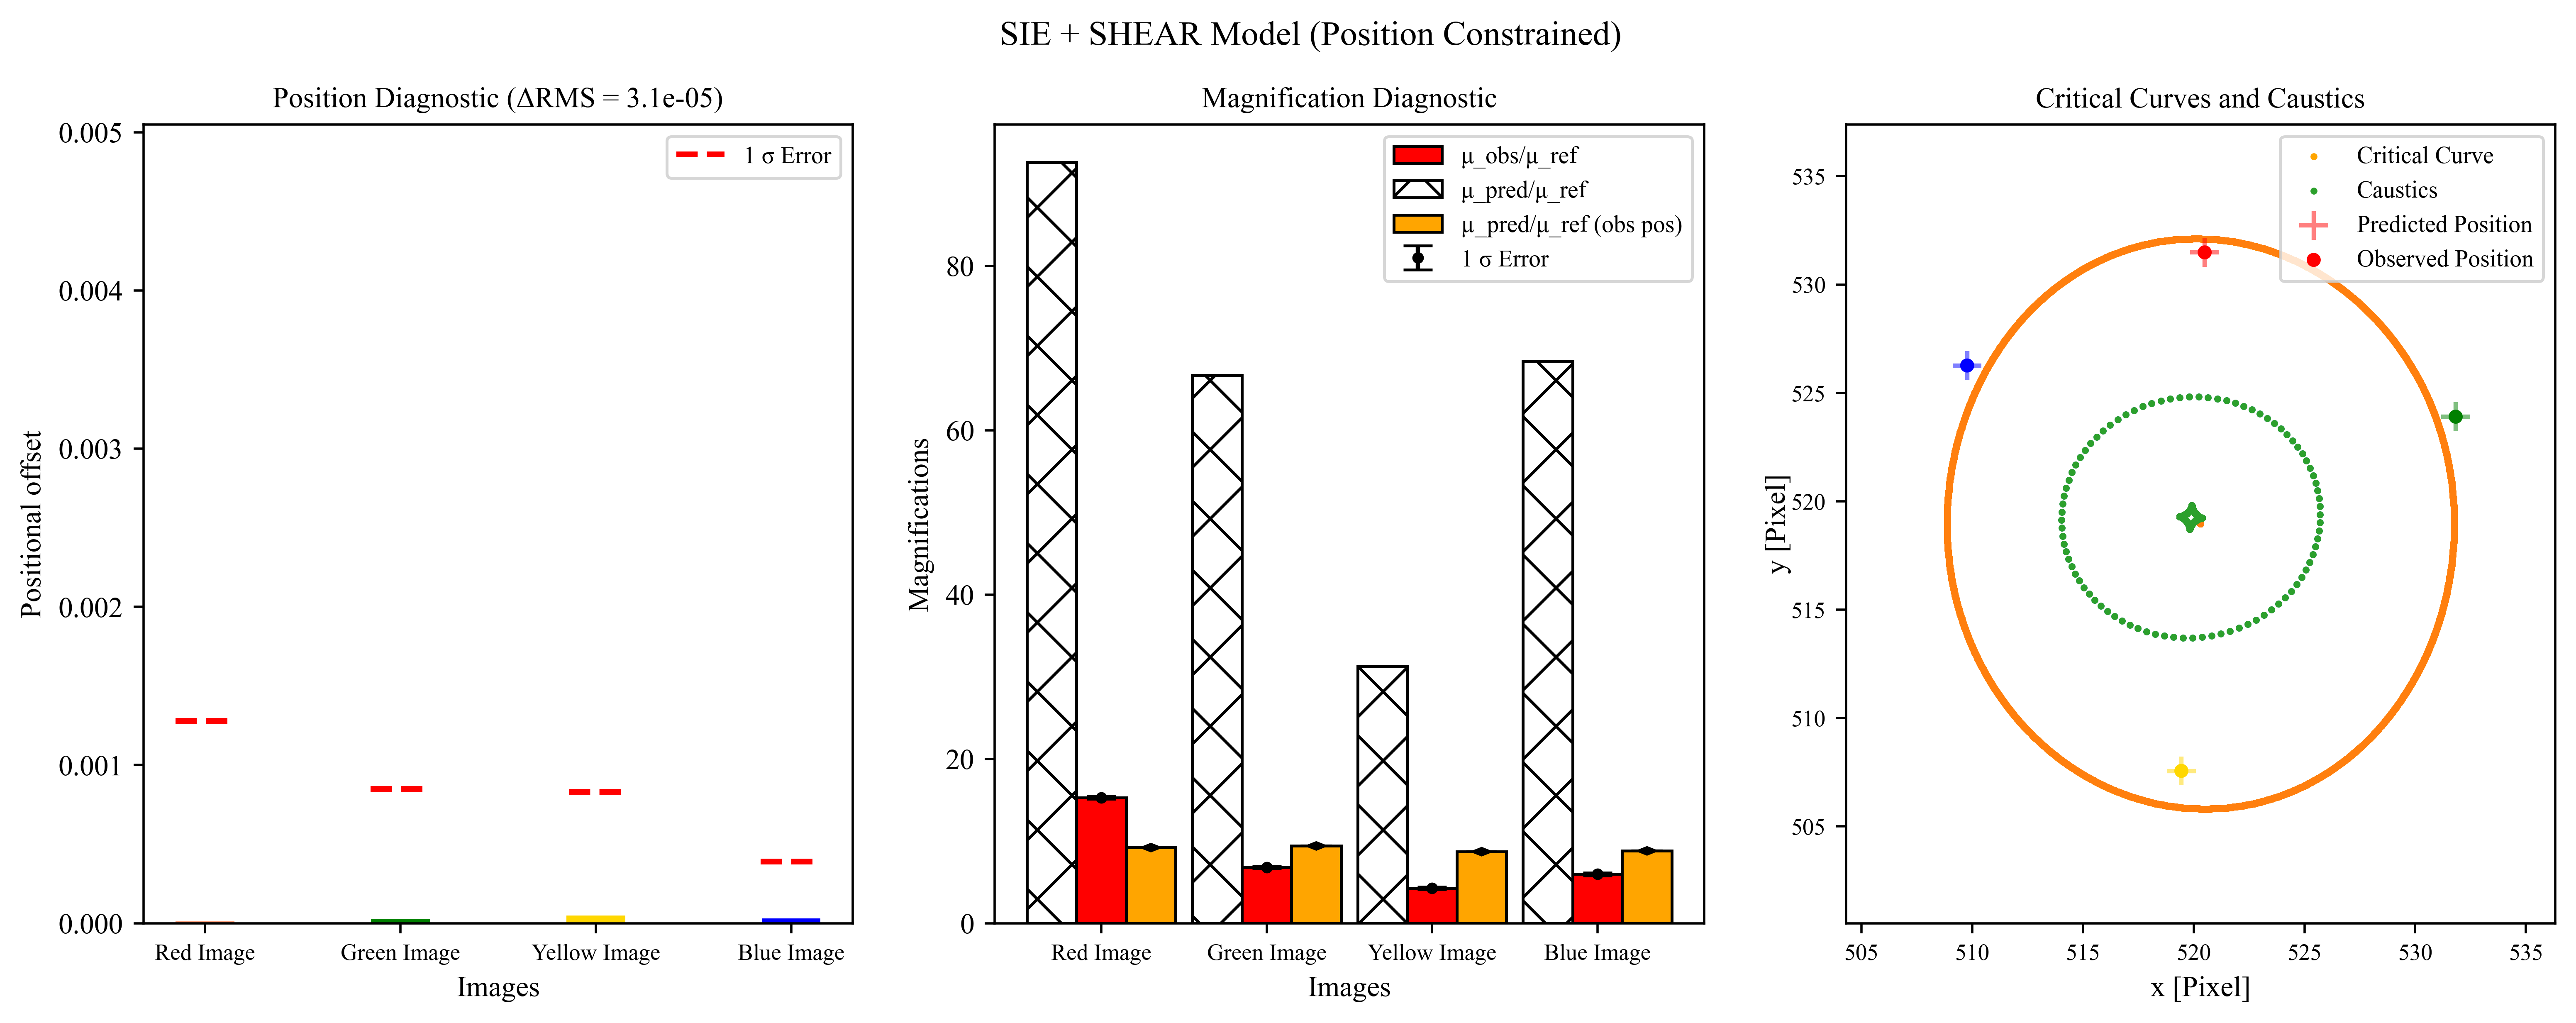

In [60]:
plot_name_1 = 'SIE_POS_SHEAR'
loc = 'Test/SIE+SHEAR/'
title = 'SIE + SHEAR Model (Position Constrained)'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, title, table_flag=False, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

RMS of the differences: 0.000031
RMS of the magnification differences: 8.079200


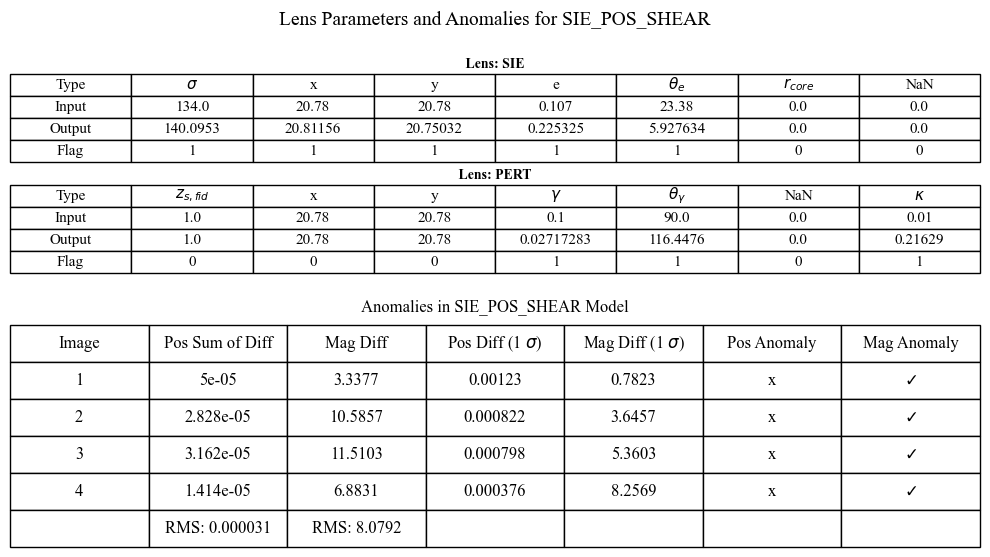

In [58]:
# Example usage
model_path = 'Test/SIE+SHEAR'
model_ver = 'SIE_POS_SHEAR'

if 'POS+FLUX' in model_ver:
    constraint = 'pos_flux'
elif 'POS' in model_ver:
    constraint = 'pos'

dfs, out_point = make_tables(model_ver, model_path, constraint)


In [ ]:
plot_single_model('Test/SIE', 'SIE_POS')

In [ ]:
plot_name_1 = 'SIE_POS_SHEAR'
loc = 'Test/SIE+SHEAR/'
title = 'SIE+SHEAR Lens Model (Position Constrained)'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + 'pos_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point_SIE(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, title, table_flag=False, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [ ]:
# Example usage
model_path = 'Test/SIE+SHEAR'
model_ver = 'SIE_POS_SHEAR'

if 'POS+FLUX' in model_ver:
    constraint = 'pos_flux'
elif 'POS' in model_ver:
    constraint = 'pos'

dfs, out_point = make_tables(model_ver, model_path, constraint)


In [ ]:
plot_single_model('Test/SIE+SHEAR', 'SIE_POS_SHEAR')

In [ ]:
compare_models('Test/SIE', 'SIE_POS', 'Test/SIE+SHEAR', 'SIE_POS_SHEAR')